In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch
import random
import zipfile
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.models as models
import torchvision.transforms as T
import torch.optim as optim
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

Fix the seed

In [4]:
TRAIN_DIR = '/kaggle/input/fruits/fruits-360_original-size/fruits-360-original-size/Training'
VAL_DIR = '/kaggle/input/fruits/fruits-360_original-size/fruits-360-original-size/Validation'


# Make the results reproducible using seed

SEED = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ['PYTHONHASHSEED'] = str(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(SEED)
random.seed(SEED)

In [5]:
train_df = pd.DataFrame(columns=('class_name', 'file_dir'))
val_df = pd.DataFrame(columns=('class_name', 'file_dir'))

for root, dirs, files in os.walk(f'{TRAIN_DIR}'):
    for target in dirs:
        for file in os.listdir(f'{TRAIN_DIR}/{target}'):
            train_df.loc[len(train_df)] = {'class_name' : target, 'file_dir': os.path.join(root, target, file)}

for root, dirs, files in os.walk(f'{VAL_DIR}'):
    for target in dirs:
        for file in os.listdir(f'{VAL_DIR}/{target}'):
            val_df.loc[len(val_df)] = {'class_name' : target, 'file_dir': os.path.join(root, target, file)}

In [6]:
train_df['class_id'] = train_df['class_name'].astype('category').cat.codes
val_df['class_id'] = val_df['class_name'].astype('category').cat.codes

In [7]:
resolutions = [Image.open(x).size for x in train_df['file_dir']]
res_counts = Counter(resolutions).most_common(10)
print("Most common resolutions:")
print(res_counts)

Most common resolutions:
[((275, 316), 33), ((178, 177), 32), ((277, 316), 26), ((278, 316), 25), ((179, 177), 25), ((137, 153), 24), ((138, 153), 23), ((180, 177), 20), ((133, 146), 19), ((136, 153), 19)]


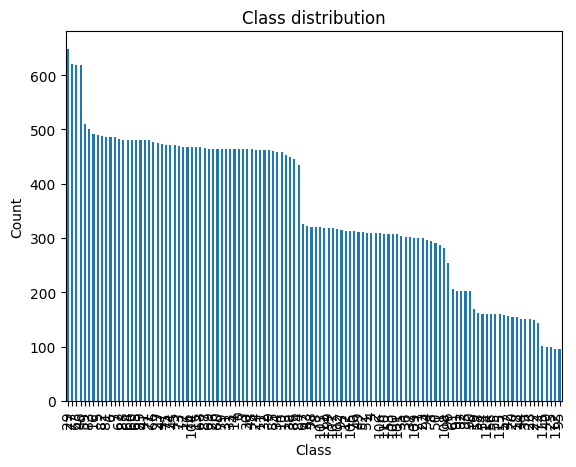

In [8]:
class_counts = train_df['class_id'].value_counts()

class_counts.plot(kind='bar')
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [9]:
class Img_Dataset(Dataset):
    def __init__(self, df, transform=None, labels=True):
        self.paths = df['file_dir'].tolist()
        self.transform = transform
        self.labels = False

        if labels:
            self.labels = df['class_id'].tolist()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.labels:
            label = self.labels[idx]
            return image, label

        return image

In [10]:
train_transform = T.Compose([
    T.Resize((320, 320)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.03),
    T.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
    T.ToTensor(),
    T.RandomErasing(p=0.25, scale=(0.02, 0.08)),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.Resize((320, 320)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [11]:
train_dataset = Img_Dataset(
    train_df,
    transform = train_transform
)

val_dataset = Img_Dataset(
    val_df,
    transform = val_transform,
)

In [12]:
# Creating a loder to load all the data

# Trying different batches starting off with 8, since we have a lot of data, but still the dataset isn't that large

BATCH = 8



# Add sample weights and weigthedrandomsampler to distribute data evenly
class_counts = train_df['class_id'].value_counts().to_dict()  # {0: n0, 1: n1}

# assign weight = 1/freq for each sample
sample_weights = train_df['class_id'].map(lambda y: 1.0 / class_counts[y]).values
sample_weights = sample_weights.astype(np.float32)

# build the sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),   # draw as many samples as dataset size
    replacement=True                   # allow resampling
)


train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH,
    num_workers = 0,
    drop_last = True, # Drop everything that remains after placing data into batches of 8
    sampler = sampler
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH,
    shuffle = False,
    num_workers = 0,
    drop_last = False
)

In [13]:
def prepare_model():

    # Load a pretrained ResNet50 backbone
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

    # Getting how many features were input for the lasat layer
    in_features = m.fc.in_features

    # Replace the 1000-class head with a single-logit head
    m.fc = nn.Linear(in_features, train_df['class_id'].nunique())
    return m


model = prepare_model()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 247MB/s]


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
scaler = torch.amp.GradScaler(DEVICE)

In [15]:
def train(model, train_loader, val_loader, optimizer, scaler, criterion, scheduler, epochs):
    model.to(DEVICE)

    best_val_f1 = -1.0
    best_f1_epoch = -1.0



    for epoch in range(epochs):
        print(f'Epoch {epoch+1}')


        model.train()
        running_loss = 0.0
        correct = 0.0
        all_preds = []
        all_labels = []

        for imgs, labels in train_loader:
            labels = labels.to(DEVICE).float().unsqueeze(1)
            imgs = imgs.to(DEVICE)

            with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
                outputs = model(imgs)
                loss = criterion(outputs, labels.long().squeeze(1))


            optimizer.zero_grad()
            if DEVICE == "cuda":
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            running_loss += loss.item()

            
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels.squeeze(1)).sum().item()
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.squeeze(1).cpu().numpy().astype(int).tolist())

        running_loss /= len(train_loader)
        train_acc = 100.0 * correct / len(train_loader.dataset)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')

        print(f'Training Loss: {running_loss:.4f}')
        print(f'Training Accuracy: {train_acc:.2f}%')
        print(f'Training F1 @0.5: {train_f1:.4f}')

        # Validating at the same time while training
        model.eval()
        with torch.no_grad():
            val_probs = []
            val_labels = []
            for imgs, labels in val_loader:
                imgs = imgs.to(DEVICE)
                logits = model(imgs)

            
                probs = torch.softmax(logits, dim=1).cpu().numpy()
                val_probs.extend(probs.tolist())
                val_labels.extend(labels.cpu().numpy().tolist())

        val_probs = np.array(val_probs)
        val_labels = np.array(val_labels)

        
        preds = np.argmax(val_probs, axis=1)
        f1 = f1_score(val_labels, preds, average='weighted')

        class_acc = {}
        for cls in np.unique(val_labels):
            mask = val_labels == cls
            class_acc[cls] = (preds[mask] == val_labels[mask]).mean()
            
        k = 10
        worst_classes = sorted(class_acc, key=class_acc.get)[:k]
        print("Worst classes:", worst_classes)

        mask = np.isin(val_labels, worst_classes)

        worst_labels = val_labels[mask]
        worst_preds = preds[mask]
        
        cm = confusion_matrix(worst_labels, worst_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title('Worst Classes Confusion Matrix')
        plt.show()


        if f1 > best_f1_epoch:
            best_f1_epoch = f1

        print(f'Validation F1 (best): {best_f1_epoch:.4f}')
        print(f'Validation F1 (current): {f1:.4f}')

        if f1>=0.95:
            return model, best_val_f1

        scheduler.step(1-f1)

        # keep the best across epochs
        if best_f1_epoch > best_val_f1:
            best_val_f1 = best_f1_epoch


    print(f'Best Val F1 over training: {best_val_f1:.4f}')
    return model, best_val_f1

Epoch 1


/tmp/ipykernel_47/2113105839.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Training Loss: 0.3882
Training Accuracy: 90.87%
Training F1 @0.5: 0.9096
Worst classes: [38, 86, 47, 64, 88, 1, 55, 75, 21, 36]


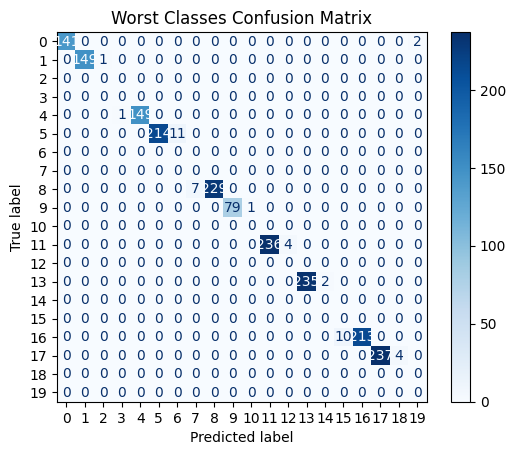

Validation F1 (best): 0.9979
Validation F1 (current): 0.9979


In [16]:
model, best_val_f1 = train(
  model,
  train_loader,
  val_loader,
  optimizer,
  scaler,
  criterion,
  scheduler,
  5,
)

In [18]:
torch.save(model.state_dict(), 'model.pth')